<a href="https://colab.research.google.com/github/nasifnur307-blip/biomarkerlink/blob/main/notebooks/setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install numpy scipy matplotlib scikit-learn pandas networkx pgmpy causal-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 32.3 MB/s eta 0:00:00


In [10]:
!pip install causal-learn==0.1.4.3



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: causal-learn
    Found existing installation: causal-learn 0.1.4.4
    Uninstalling causal-learn-0.1.4.4:
      Successfully uninstalled causal-learn-0.1.4.4


In [11]:
# lowercase causallearn
from causallearn.search.ConstraintBased.PC import pc


In [12]:
from sklearn.preprocessing import StandardScaler


In [13]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from causallearn.search.ConstraintBased.PC import pc

print("Ready.")


Ready.


In [14]:
import os
from google.colab import drive
import shutil

mount_path = '/content/drive'

# Attempt to unmount if it's already mounted
try:
    drive.flush_and_unmount()
except ValueError: # Not mounted
    pass

# Ensure the mount_path directory is completely removed before attempting to mount
if os.path.exists(mount_path):
    print(f"Removing existing directory: {mount_path}")
    try:
        shutil.rmtree(mount_path)
    except Exception as e:
        print(f"Error removing {mount_path}: {e}. You may need to restart the runtime.")
        # If we can't remove, the mount will likely fail again. It might require a runtime restart.

# Recreate the directory (drive.mount usually creates it if it doesn't exist, but for safety)
os.makedirs(mount_path, exist_ok=True)

# Now mount Drive
drive.mount(mount_path, force_remount=True)

# Then the git clone
!git clone https://github.com/nasifnur307-blip/biomarkerlink.git

Drive not mounted, so nothing to flush and unmount.
Removing existing directory: /content/drive
Mounted at /content/drive
Cloning into 'biomarkerlink'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 53 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 55.82 KiB | 3.99 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [17]:
import os

folders = [
    "data/raw",
    "data/processed",
    "results/graphs",
    "results/models",
]

for f in folders:
    os.makedirs(f, exist_ok=True)

print("Folders created.")


Folders created.


In [18]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 54.8 MB/s eta 0:00:00


In [19]:
import mne
import os

print("MNE-Python and os libraries imported successfully.")

MNE-Python and os libraries imported successfully.


In [ ]:
import mne
import os
import numpy as np
import h5py
from mne.preprocessing import ICA

mne.set_log_level('WARNING')

raw_data_base_dir = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf'
processed_output_hdf5_path = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data.h5'

# Ensure the output directory for the HDF5 file exists
os.makedirs(os.path.dirname(processed_output_hdf5_path), exist_ok=True)

edf_files = []
for root, _, files in os.walk(raw_data_base_dir):
    for file in files:
        if file.endswith('.edf'):
            edf_files.append(os.path.join(root, file))

if not edf_files:
    print(f"No EDF files found in {raw_data_base_dir} or its subdirectories.")
    print("Skipping preprocessing, ICA, and segmentation.")
else:
    print(f"Found {len(edf_files)} EDF files in {raw_data_base_dir} and its subdirectories.")
    print(f"Total {len(edf_files)} EDF files to process.")

    low_freq = 0.5
    high_freq = 45
    new_sfreq = 100 # Hz
    segment_duration = 5 # seconds

    # Initialize HDF5 file for incremental saving
    hdf5_file = None
    dataset = None
    initial_segment_shape = None # To store shape of one reshaped segment (n_channels * n_times)

    for i, edf_file in enumerate(edf_files):
        print(f"\nProcessing file {i+1}/{len(edf_files)}: {os.path.basename(edf_file)}")
        try:
            # 1. Load and Preprocess Raw data
            raw = mne.io.read_raw_edf(edf_file, preload=True)
            raw.info['description'] = os.path.basename(edf_file).replace('.edf', '')
            # Set montage before re-referencing for better accuracy if channel locations are available
            # raw.set_montage('standard_1020') # Example, uncomment if needed and appropriate

            print(f"  Original sampling frequency: {raw.info['sfreq']} Hz")
            print(f"  Number of channels: {len(raw.ch_names)}")
            print(f"  Duration: {raw.times[-1] / 60:.2f} minutes")

            eeg_channels = mne.pick_types(raw.info, eeg=True, exclude='bads')
            if len(eeg_channels) > 0:
                raw.set_eeg_reference(ref_channels='average')
                print("  Applied Common Average Reference.")
            else:
                print("  No EEG channels found for re-referencing.")

            raw.filter(l_freq=low_freq, h_freq=high_freq, picks='eeg')
            print(f"  Applied bandpass filter ({low_freq}-{high_freq} Hz).")
            raw.resample(sfreq=new_sfreq)
            print(f"  Downsampled to {raw.info['sfreq']} Hz.")

            # 2. Apply ICA Cleaning
            # Ensure enough samples for ICA fit; if raw data is very short, ICA might fail.
            # For very short files, ICA might not be applicable or need adjustments.
            # We fit ICA on the preprocessed raw data directly.
            n_components_ica = min(20, len(raw.ch_names)) # Max 20 components or num channels
            ica = ICA(n_components=n_components_ica, random_state=99, verbose=False)

            # Fit ICA. MNE's ICA can be memory intensive; using a copy to avoid inplace modification before apply.
            # If memory still an issue, consider fitting ICA on a representative shorter segment or reducing n_components_ica further.
            ica.fit(raw.copy().pick_types(eeg=True)) # Fitting ICA on a copy of preprocessed raw

            ica_cleaned_raw = ica.apply(raw, exclude=ica.exclude, verbose=False) # Apply ICA directly to original preprocessed raw
            print(f"    ICA applied. Original channels: {len(raw.ch_names)}, ICA components: {ica.n_components_}, Excluded components: {len(ica.exclude)}")
            del raw, ica # Free memory from raw object and ICA fitter

            # 3. Segment data
            epochs = mne.make_fixed_length_epochs(ica_cleaned_raw, duration=segment_duration, overlap=0, preload=True, verbose=False)
            print(f"    Created {len(epochs)} epochs, each {segment_duration} seconds long.")
            epochs_data = epochs.get_data(picks='eeg')
            n_epochs, n_channels, n_times = epochs_data.shape
            reshaped_epochs_data = epochs_data.reshape(n_epochs, n_channels * n_times)
            del ica_cleaned_raw, epochs # Free memory from ICA cleaned raw and epochs

            # 4. Incrementally save to HDF5
            if hdf5_file is None:
                # First file, create the HDF5 dataset
                hdf5_file = h5py.File(processed_output_hdf5_path, 'w')
                initial_segment_shape = reshaped_epochs_data.shape[1]
                # Create a resizable dataset
                dataset = hdf5_file.create_dataset('eeg_segments', data=reshaped_epochs_data,
                                                   maxshape=(None, initial_segment_shape),
                                                   compression="gzip", compression_opts=9)
                print(f"  Initialized HDF5 dataset at {processed_output_hdf5_path} with shape {dataset.shape}")
            else:
                # Append subsequent data
                dataset.resize(dataset.shape[0] + reshaped_epochs_data.shape[0], axis=0)
                dataset[-reshaped_epochs_data.shape[0]:] = reshaped_epochs_data
                print(f"  Appended {reshaped_epochs_data.shape[0]} segments. Current HDF5 dataset shape: {dataset.shape}")

        except Exception as e:
            print(f"  Error processing {os.path.basename(edf_file)}: {e}")

    if hdf5_file:
        hdf5_file.close()
        print(f"\nFinished processing all files and saved segmented EEG data to: {processed_output_hdf5_path}")
        print(f"Total segments saved: {dataset.shape[0]}")
    else:
        print("\nNo EDF files were successfully processed and saved to HDF5.")

In [18]:
import mne
print(f"MNE-Python version: {mne.__version__}")

MNE-Python version: 1.11.0


In [3]:
!pip install awscli

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9.1
    Uninstalling rsa-4.9.1:
      Successfully uninstalled rsa-4.9.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.


In [8]:
!aws s3 sync --no-sign-request s3://physionet-open/chbmit/1.0.0/ /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf

In [15]:
!aws s3 sync --no-sign-request s3://physionet-open/chbmit/1.0.0/ /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf

download: s3://physionet-open/chbmit/1.0.0/SUBJECT-INFO to drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/SUBJECT-INFO
download: s3://physionet-open/chbmit/1.0.0/ANNOTATORS to drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/ANNOTATORS
download: s3://physionet-open/chbmit/1.0.0/RECORDS to drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/RECORDS
download: s3://physionet-open/chbmit/1.0.0/chb01/chb01_03.edf.seizures to drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/chb01/chb01_03.edf.seizures
download: s3://physionet-open/chbmit/1.0.0/RECORDS-WITH-SEIZURES to drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/RECORDS-WITH-SEIZURES
download: s3://physionet-open/chbmit/1.0.0/chb01/chb01-summary.txt to drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/chb01/chb01-summary.txt
download: s3://physionet-open/chbmit/1.0.0/SHA256SUMS.txt to drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/SHA256SUMS.txt
download: s3://physionet-open/chbmit/

In [24]:
from mne.preprocessing import ICA


processed_data_dir = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed'
os.makedirs(processed_data_dir, exist_ok=True)


ica_cleaned_fif_paths = []


if preprocessed_raw_objects:
    print(f"\nApplying ICA to {len(preprocessed_raw_objects)} preprocessed Raw objects and saving them...")
    for i, raw_obj in enumerate(preprocessed_raw_objects):
        # Use the description set in the previous step, or a generic name if unavailable
        original_filename = raw_obj.info['description'] if raw_obj.info['description'] else f'unnamed_raw_{i}'
        output_fif_path = os.path.join(processed_data_dir, f'{original_filename}_ica_cleaned.fif')

        # Check if ICA-cleaned file already exists to avoid reprocessing
        if os.path.exists(output_fif_path):
            print(f"  Skipping ICA for {original_filename} as {output_fif_path} already exists.")

            continue

        print(f"  Processing raw object {i+1}/{len(preprocessed_raw_objects)}: {original_filename}")
        try:

            n_components_ica = min(20, len(raw_obj.ch_names))
            ica = ICA(n_components=n_components_ica, random_state=99, verbose=False)


            ica.fit(raw_obj)


            ica_cleaned_raw = ica.apply(raw_obj.copy(), exclude=ica.exclude, verbose=False)
            print(f"    ICA applied. Original channels: {len(raw_obj.ch_names)}, ICA components: {ica.n_components_}, Excluded components: {len(ica.exclude)}")


            ica_cleaned_raw.set_meas_date(None)



            ica_cleaned_raw.save(output_fif_path, overwrite=True, verbose=False)
            print(f"    Saved ICA-cleaned data to: {output_fif_path}")

        except Exception as e:
            print(f"  Error applying ICA to raw object {i+1} ({original_filename}): {e}")


ica_cleaned_fif_paths = [os.path.join(processed_data_dir, f) for f in os.listdir(processed_data_dir) if f.endswith('_ica_cleaned.fif') or f.endswith('_ica_cleaned.fif.gz')]

if ica_cleaned_fif_paths:
    print(f"\nFinished ICA cleaning and saving. Total {len(ica_cleaned_fif_paths)} ICA-cleaned .fif files found on disk.")
    print("List of ICA-cleaned .fif files:", ica_cleaned_fif_paths)
else:
    print("\nNo ICA-cleaned .fif files were found on disk. Please ensure EDF files are present in the raw data directory and processed in previous steps, and ICA runs successfully.")


Applying ICA to 20 preprocessed Raw objects and saving them...
  Processing raw object 1/20: chb08_21
    ICA applied. Original channels: 23, ICA components: 20, Excluded components: 0


/tmp/ipython-input-4269725839.py:42: RuntimeWarning: This filename (/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed/chb08_21_ica_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  ica_cleaned_raw.save(output_fif_path, overwrite=True, verbose=False)


    Saved ICA-cleaned data to: /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed/chb08_21_ica_cleaned.fif
  Processing raw object 2/20: chb08_23
  Error applying ICA to raw object 2 (chb08_23): File /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/chb08_23.edf not found.
  Processing raw object 3/20: chb08_11
  Error applying ICA to raw object 3 (chb08_11): File /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/chb08_11.edf not found.
  Processing raw object 4/20: chb08_29
  Error applying ICA to raw object 4 (chb08_29): File /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/chb08_29.edf not found.
  Processing raw object 5/20: chb08_24
  Error applying ICA to raw object 5 (chb08_24): File /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/chb08_24.edf not found.
  Processing raw object 6/20: chb08_02
  Error applying ICA to raw object 6 (chb08_02): File /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.0

KeyboardInterrupt: 

In [ ]:
import numpy as np

# 1. Define segmentation parameters
segment_duration = 5 # seconds

# 2. Initialize an empty list to store the extracted data from each segment
segmented_data_for_causal_analysis = []

# 3. Iterate through each ICA-cleaned .fif file path
if 'ica_cleaned_fif_paths' in locals() and ica_cleaned_fif_paths:
    print(f"\nSegmenting data from {len(ica_cleaned_fif_paths)} ICA-cleaned .fif files...")
    for i, fif_path in enumerate(ica_cleaned_fif_paths):
        filename = os.path.basename(fif_path)
        print(f"  Segmenting file {i+1}/{len(ica_cleaned_fif_paths)}: {filename}")
        try:
            # Load the ICA-cleaned Raw object from the .fif file
            raw_obj = mne.io.read_raw_fif(fif_path, preload=True, verbose=False)

            # 4. Create non-overlapping epochs (segments) of the defined duration
            epochs = mne.make_fixed_length_epochs(raw_obj, duration=segment_duration, overlap=0, preload=True, verbose=False)
            print(f"    Created {len(epochs)} epochs, each {segment_duration} seconds long.")

            # 5. Extract the numerical data from each epoch and prepare for causal inference
            epochs_data = epochs.get_data(picks='eeg')

            n_epochs, n_channels, n_times = epochs_data.shape
            reshaped_epochs_data = epochs_data.reshape(n_epochs, n_channels * n_times)

            segmented_data_for_causal_analysis.append(reshaped_epochs_data)

            # Explicitly delete objects to free memory after processing a chunk
            del epochs, raw_obj

        except Exception as e:
            print(f"  Error segmenting file {i+1} ({filename}): {e}")

    # Concatenate all segmented data if multiple files were processed
    if segmented_data_for_causal_analysis:
        all_segmented_data = np.vstack(segmented_data_for_causal_analysis)
        print(f"\nFinished segmentation. Processed {len(ica_cleaned_fif_paths)} files and created a total of {all_segmented_data.shape[0]} segments.")
        print(f"Shape of combined segmented data for causal analysis: {all_segmented_data.shape}")
    else:
        print("No segments were successfully created for causal analysis.")
else:
    print("\nNo ICA-cleaned .fif file paths available for segmentation. Please ensure ICA cleaning and saving steps ran successfully.")

In [ ]:
import h5py
import os

# 1. Check if segmented data exists
if 'all_segmented_data' in locals() and all_segmented_data.size > 0:
    data_to_save = all_segmented_data
    print(f"Data to save found with shape: {data_to_save.shape}")
elif segmented_data_for_causal_analysis:

    data_to_save = np.vstack(segmented_data_for_causal_analysis)
    print(f"Data to save found in list form with shape: {data_to_save.shape}")
else:
    print("No segmented data available to save. Please ensure previous steps ran successfully.")
    data_to_save = None

if data_to_save is not None:
    # 2. Define filename and path
    processed_data_dir = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final'
    os.makedirs(processed_data_dir, exist_ok=True)
    output_filename = os.path.join(processed_data_dir, 'segmented_eeg_data.h5')

    # 4. Use h5py.File() to create or open an HDF5 file
    with h5py.File(output_filename, 'w') as f:
        # 5. Save the NumPy array as a dataset within the HDF5 file with compression
        f.create_dataset('eeg_segments', data=data_to_save, compression="gzip", compression_opts=9)

    print(f"Successfully saved segmented EEG data to: {output_filename}")
    print(f"Saved data shape: {data_to_save.shape}")


In [ ]:
import numpy as np
import os # Ensure os is imported
import mne # Ensure mne is imported as it's used later in the cell

# Explicitly define processed_data_dir
processed_data_dir = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed'

# Re-populate ica_cleaned_fif_paths by scanning the directory
# This assumes processed_data_dir exists and contains files.
ica_cleaned_fif_paths = [os.path.join(processed_data_dir, f) for f in os.listdir(processed_data_dir) if f.endswith('_ica_cleaned.fif') or f.endswith('_ica_cleaned.fif.gz')]

# 1. Define segmentation parameters
segment_duration = 5 # seconds

# 2. Initialize an empty list to store the extracted data from each segment
segmented_data_for_causal_analysis = []

# 3. Iterate through each ICA-cleaned .fif file path
# The original 'if' condition is simplified since ica_cleaned_fif_paths is now explicitly populated.
if ica_cleaned_fif_paths:
    print(f"\nSegmenting data from {len(ica_cleaned_fif_paths)} ICA-cleaned .fif files...")
    for i, fif_path in enumerate(ica_cleaned_fif_paths):
        filename = os.path.basename(fif_path)
        print(f"  Segmenting file {i+1}/{len(ica_cleaned_fif_paths)}: {filename}")
        try:
            # Load the ICA-cleaned Raw object from the .fif file
            raw_obj = mne.io.read_raw_fif(fif_path, preload=True, verbose=False)

            # 4. Create non-overlapping epochs (segments) of the defined duration
            epochs = mne.make_fixed_length_epochs(raw_obj, duration=segment_duration, overlap=0, preload=True, verbose=False)
            print(f"    Created {len(epochs)} epochs, each {segment_duration} seconds long.")

            # 5. Extract the numerical data from each epoch and prepare for causal inference
            epochs_data = epochs.get_data(picks='eeg')

            n_epochs, n_channels, n_times = epochs_data.shape
            # Reshape each epoch into a single row vector
            # This creates a 2D array where each row is a flattened epoch
            reshaped_epochs_data = epochs_data.reshape(n_epochs, n_channels * n_times)

            segmented_data_for_causal_analysis.append(reshaped_epochs_data)

            # Explicitly delete objects to free memory after processing a chunk
            del epochs, raw_obj

        except Exception as e:
            print(f"  Error segmenting file {i+1} ({filename}): {e}")

    # Concatenate all segmented data if multiple files were processed
    if segmented_data_for_causal_analysis:
        all_segmented_data = np.vstack(segmented_data_for_causal_analysis)
        print(f"\nFinished segmentation. Processed {len(ica_cleaned_fif_paths)} files and created a total of {all_segmented_data.shape[0]} segments.")
        print(f"Shape of combined segmented data for causal analysis: {all_segmented_data.shape}")
    else:
        print("No segments were successfully created for causal analysis.")
else:
    print("\nNo ICA-cleaned .fif file paths found in the specified directory. Please ensure ICA cleaning and saving steps ran successfully.")

In [ ]:
import h5py
import os

# 1. Check if segmented data exists
if 'all_segmented_data' in locals() and all_segmented_data.size > 0:
    data_to_save = all_segmented_data
    print(f"Data to save found with shape: {data_to_save.shape}")
elif segmented_data_for_causal_analysis:

    data_to_save = np.vstack(segmented_data_for_causal_analysis)
    print(f"Data to save found in list form with shape: {data_to_save.shape}")
else:
    print("No segmented data available to save. Please ensure previous steps ran successfully.")
    data_to_save = None

if data_to_save is not None:
    # 2. Define filename and path
    processed_data_dir = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final'
    os.makedirs(processed_data_dir, exist_ok=True)
    output_filename = os.path.join(processed_data_dir, 'segmented_eeg_data.h5')

    # 4. Use h5py.File() to create or open an HDF5 file
    with h5py.File(output_filename, 'w') as f:
        # 5. Save the NumPy array as a dataset within the HDF5 file with compression
        f.create_dataset('eeg_segments', data=data_to_save, compression="gzip", compression_opts=9)

    print(f"Successfully saved segmented EEG data to: {output_filename}")
    print(f"Saved data shape: {data_to_save.shape}")

In [6]:
%%writefile /content/d6f72e3a_modified.py

import h5py
import numpy as np
import mne
import os
from mne.preprocessing import ICA # Ensure ICA is imported
import sys # Import sys for sys.exit()

# --- Configuration for Data Preprocessing and HDF5 Saving ---
raw_data_base_dir = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/'
processed_output_hdf5_path = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data_subset.h5' # Changed output filename to avoid overwriting previous attempts

# Ensure the output directory for the HDF5 file exists
os.makedirs(os.path.dirname(processed_output_hdf5_path), exist_ok=True)

edf_files_full_list = []
for root, _, files in os.walk(raw_data_base_dir):
    for file in files:
        if file.endswith('.edf'):
            edf_files_full_list.append(os.path.join(root, file))

# --- Process only a small subset of EDF files ---
# Using the first 5 files from the discovered list for quick testing
edf_files = edf_files_full_list[:5] # Take only the first 5 files

if not edf_files:
    print(f"No EDF files found in {raw_data_base_dir} or its subdirectories. Please ensure data is downloaded.")
    sys.exit() # Exit if no EDF files are found
else:
    print(f"Found {len(edf_files_full_list)} total EDF files. Processing a subset of {len(edf_files)} files.")

    low_freq = 0.5
    high_freq = 45
    new_sfreq = 100 # Hz
    segment_duration = 5 # seconds

    # Initialize HDF5 file for incremental saving
    hdf5_file = None
    dataset = None
    initial_segment_shape = None
    all_channel_names = None # To store channel names from the first processed file
    total_segments_saved = 0 # Track total segments

    for i, edf_file in enumerate(edf_files):
        print(f"\nProcessing file {i+1}/{len(edf_files)}: {os.path.basename(edf_file)}")
        try:
            raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
            raw.info['description'] = os.path.basename(edf_file).replace('.edf', '')

            # Store channel names from the first file. Assumes consistent channel names across files.
            if all_channel_names is None:
                all_channel_names = raw.ch_names

            eeg_channels = mne.pick_types(raw.info, eeg=True, exclude='bads')
            if len(eeg_channels) > 0:
                raw.set_eeg_reference(ref_channels='average', verbose=False)
                print("  Applied Common Average Reference.")
            else:
                print("  No EEG channels found for re-referencing. Skipping.")
                del raw # Free memory
                continue # Skip this file

            raw.filter(l_freq=low_freq, h_freq=high_freq, picks='eeg', verbose=False)
            print(f"  Applied bandpass filter ({low_freq}-{high_freq} Hz).")
            raw.resample(sfreq=new_sfreq, verbose=False)
            print(f"  Downsampled to {raw.info['sfreq']} Hz.")

            # --- ICA cleaning is TEMPORARILY DISABLED as per subtask instructions ---
            # n_components_ica = min(20, len(raw.ch_names))
            # ica = ICA(n_components=n_components_ica, random_state=99, verbose=False)
            # ica.fit(raw.copy().pick_types(eeg=True, meg=False))
            # ica_cleaned_raw = ica.apply(raw, exclude=ica.exclude, verbose=False)
            # print(f"    ICA applied. Original channels: {len(raw.ch_names)}, ICA components: {ica.n_components_}, Excluded components: {len(ica.exclude)}")
            # del raw, ica # Free memory
            # Use raw directly for segmentation since ICA is disabled
            processed_raw = raw
            del raw # Free memory

            epochs = mne.make_fixed_length_epochs(processed_raw, duration=segment_duration, overlap=0, preload=True, verbose=False)
            print(f"    Created {len(epochs)} epochs, each {segment_duration} seconds long.")
            epochs_data = epochs.get_data(picks='eeg')
            n_epochs, n_channels, n_times = epochs_data.shape
            reshaped_epochs_data = epochs_data.reshape(n_epochs, n_channels * n_times)
            del processed_raw, epochs # Free memory

            if hdf5_file is None:
                hdf5_file = h5py.File(processed_output_hdf5_path, 'w')
                initial_segment_shape = reshaped_epochs_data.shape[1]
                dataset = hdf5_file.create_dataset('eeg_segments', data=reshaped_epochs_data,
                                                   maxshape=(None, initial_segment_shape),
                                                   compression="gzip", compression_opts=9)
                # Crucial fix: Save channel names as an attribute
                # Make sure all_channel_names is not None if files were processed
                if all_channel_names:
                    hdf5_file.attrs['channel_names'] = [ch.encode('utf-8') for ch in all_channel_names] # Save as bytes
                else:
                    print("Warning: No channel names were collected. HDF5 will not have channel_names attribute.")
                print(f"  Initialized HDF5 dataset at {processed_output_hdf5_path} with shape {dataset.shape}")
                total_segments_saved += reshaped_epochs_data.shape[0]
            else:
                dataset.resize(dataset.shape[0] + reshaped_epochs_data.shape[0], axis=0)
                dataset[-reshaped_epochs_data.shape[0]:] = reshaped_epochs_data
                print(f"  Appended {reshaped_epochs_data.shape[0]} segments. Current HDF5 dataset shape: {dataset.shape}")
                total_segments_saved += reshaped_epochs_data.shape[0]

        except Exception as e:
            print(f"  Error processing {os.path.basename(edf_file)}: {e}")

    if hdf5_file:
        hdf5_file.close()
        print(f"\nFinished processing all files and saved segmented EEG data to: {processed_output_hdf5_path}")
        print(f"Total segments saved: {total_segments_saved}")
    else:
        print("\nNo EDF files were successfully processed and saved to HDF5.")
        sys.exit()


Overwriting /content/d6f72e3a_modified.py


In [9]:
%run /content/d6f72e3a_modified.py

Found 686 total EDF files. Processing a subset of 5 files.

Processing file 1/5: chb01_02.edf


/content/d6f72e3a_modified.py:47: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


  Applied Common Average Reference.
  Applied bandpass filter (0.5-45 Hz).
  Downsampled to 100.0 Hz.
    Created 720 epochs, each 5 seconds long.
  Initialized HDF5 dataset at /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data_subset.h5 with shape (720, 11500)

Processing file 2/5: chb01_04.edf


/content/d6f72e3a_modified.py:47: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


  Applied Common Average Reference.
  Applied bandpass filter (0.5-45 Hz).
  Downsampled to 100.0 Hz.
    Created 720 epochs, each 5 seconds long.
  Appended 720 segments. Current HDF5 dataset shape: (1440, 11500)

Processing file 3/5: chb01_03.edf


/content/d6f72e3a_modified.py:47: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


  Applied Common Average Reference.
  Applied bandpass filter (0.5-45 Hz).
  Downsampled to 100.0 Hz.
    Created 720 epochs, each 5 seconds long.
  Appended 720 segments. Current HDF5 dataset shape: (2160, 11500)

Processing file 4/5: chb01_01.edf


/content/d6f72e3a_modified.py:47: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


  Applied Common Average Reference.
  Applied bandpass filter (0.5-45 Hz).
  Downsampled to 100.0 Hz.
    Created 720 epochs, each 5 seconds long.
  Appended 720 segments. Current HDF5 dataset shape: (2880, 11500)

Processing file 5/5: chb01_05.edf


/content/d6f72e3a_modified.py:47: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


  Applied Common Average Reference.
  Applied bandpass filter (0.5-45 Hz).
  Downsampled to 100.0 Hz.
    Created 720 epochs, each 5 seconds long.
  Appended 720 segments. Current HDF5 dataset shape: (3600, 11500)

Finished processing all files and saved segmented EEG data to: /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data_subset.h5
Total segments saved: 3600


In [31]:
%%writefile /content/d6f72e3a_modified.py

import h5py
import numpy as np
import mne
import os
from mne.preprocessing import ICA # Ensure ICA is imported
import sys # Import sys for sys.exit()
import re # For regex to parse summary files

# Set MNE log level to WARNING to suppress verbose output
mne.set_log_level('WARNING')


raw_data_base_dir = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/CHB.05_05.edf/'
processed_output_hdf5_path = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data_full_with_ica_metadata.h5'

# Ensure the output directory for the HDF5 file exists
os.makedirs(os.path.dirname(processed_output_hdf5_path), exist_ok=True)


if os.path.exists(processed_output_hdf5_path):
    os.remove(processed_output_hdf5_path)
    print(f"Removed existing HDF5 file: {processed_output_hdf5_path}")

edf_files_full_list = []
# Iterate through subject folders within the raw_data_base_dir
for root, _, files in os.walk(raw_data_base_dir):
    for file in files:
        if file.endswith('.edf'):
            edf_files_full_list.append(os.path.join(root, file))


# Using the first 5 files from the discovered list for quick testing
edf_files_full_list.sort() # Sort to ensure consistent selection
edf_files = edf_files_full_list[:5]

if not edf_files:
    print(f"No EDF files found in {raw_data_base_dir} or its subdirectories. Please ensure data is downloaded.")
    sys.exit() # Exit if no EDF files are found
else:
    print(f"Found {len(edf_files_full_list)} total EDF files. Processing a subset of {len(edf_files)} files.")

    low_freq = 0.5
    high_freq = 45
    new_sfreq = 100 # Hz
    segment_duration = 5 # seconds
    pre_ictal_window_sec = 1800 # 30 minutes before seizure onset, for pre-ictal state

    # Initialize HDF5 file for incremental saving
    hdf5_file = None
    eeg_dataset = None
    seizure_state_dataset = None # New dataset for seizure state labels
    initial_segment_shape = None
    all_channel_names = None
    total_segments_saved = 0

    def parse_seizure_summary(summary_file_path, edf_filename):
        seizure_events = []
        try:
            with open(summary_file_path, 'r') as f:
                content = f.read()
            # Find the section for the specific EDF file
            # Corrected: Escape potential regex special characters in edf_filename_only
            edf_filename_only = os.path.basename(edf_filename)
            file_pattern = re.compile(rf"File Name: {re.escape(edf_filename_only)}\s*(.*?)(?=(File Name:|$))", re.DOTALL)
            match = file_pattern.search(content)

            if match:
                file_content = match.group(1)
                seizure_start_times = re.findall(r"Seizure Start Time: (\d+) seconds", file_content)
                seizure_end_times = re.findall(r"Seizure End Time: (\d+) seconds", file_content)

                for start, end in zip(seizure_start_times, seizure_end_times):
                    seizure_events.append((int(start), int(end)))
        except FileNotFoundError:
            print(f"  Summary file not found for {edf_filename_only}: {summary_file_path}")
        return seizure_events

    for i, edf_file in enumerate(edf_files):
        print(f"\nProcessing file {i+1}/{len(edf_files)}: {os.path.basename(edf_file)}")
        try:
            raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
            raw.info['description'] = os.path.basename(edf_file).replace('.edf', '')

            if all_channel_names is None:
                # Store channel names from the first file. MNE automatically handles duplicate names with suffixes.
                all_channel_names = raw.ch_names
                all_channel_names_encoded = [ch.encode('utf-8') for ch in all_channel_names]


            eeg_channels = mne.pick_types(raw.info, eeg=True, exclude='bads')
            if len(eeg_channels) == 0:
                print("  No EEG channels found for processing. Skipping this file.")
                del raw
                continue

            raw.set_eeg_reference(ref_channels='average', verbose=False)
            print("  Applied Common Average Reference.")

            raw.filter(l_freq=low_freq, h_freq=high_freq, picks='eeg', verbose=False)
            print(f"  Applied bandpass filter ({low_freq}-{high_freq} Hz).")
            raw.resample(sfreq=new_sfreq, verbose=False)
            print(f"  Downsampled to {raw.info['sfreq']} Hz.")

            # Re-enable ICA cleaning
            n_components_ica = min(20, len(raw.ch_names))
            ica = ICA(n_components=n_components_ica, random_state=99, verbose=False)
            ica.fit(raw.copy().pick_types(eeg=True, meg=False))
            ica_cleaned_raw = ica.apply(raw, exclude=ica.exclude, verbose=False)
            print(f"    ICA applied. Original channels: {len(raw.ch_names)}, ICA components: {ica.n_components_}, Excluded components: {len(ica.exclude)}")
            del raw, ica # Free memory

            epochs = mne.make_fixed_length_epochs(ica_cleaned_raw, duration=segment_duration, overlap=0, preload=True, verbose=False)
            print(f"    Created {len(epochs)} epochs, each {segment_duration} seconds long.")
            epochs_data = epochs.get_data(picks='eeg')
            n_epochs, n_channels, n_times = epochs_data.shape
            reshaped_epochs_data = epochs_data.reshape(n_epochs, n_channels * n_times)
            del ica_cleaned_raw # Free memory


            # Determine the summary file path for the current EDF file
            subject_folder_name = os.path.basename(os.path.dirname(edf_file))
            summary_file_path = os.path.join(raw_data_base_dir, subject_folder_name, f"{subject_folder_name}-summary.txt")
            seizure_events = parse_seizure_summary(summary_file_path, os.path.basename(edf_file))
            print(f"  Found {len(seizure_events)} seizure events for {os.path.basename(edf_file)}: {seizure_events}")

            current_file_seizure_labels = []
            for epoch_idx in range(len(epochs)):
                # Correct calculation of absolute time of epoch within the original EDF file context
                epoch_start_time_abs = epochs.events[epoch_idx, 0] / new_sfreq
                epoch_end_time_abs = epoch_start_time_abs + segment_duration

                label = 'inter-ictal' # Default label

                for seizure_start, seizure_end in seizure_events:
                    # Check for ictal state (any overlap)
                    if (epoch_start_time_abs < seizure_end and epoch_end_time_abs > seizure_start):
                        label = 'ictal'
                        break

                # If not ictal, check for pre-ictal
                if label == 'inter-ictal': # Only check pre-ictal if not already ictal
                    for seizure_start, _ in seizure_events:
                        # Ensure seizure_start - pre_ictal_window_sec is not negative
                        pre_ictal_start = max(0, seizure_start - pre_ictal_window_sec)
                        if (pre_ictal_start <= epoch_start_time_abs < seizure_start):
                            label = 'pre-ictal'
                            break

                current_file_seizure_labels.append(label)

            current_file_seizure_labels_np = np.array(current_file_seizure_labels, dtype='S10') # Store as byte strings, max length 10 for 'inter-ictal'
            del epochs # Free memory


            if hdf5_file is None:
                # First file, create the HDF5 dataset
                hdf5_file = h5py.File(processed_output_hdf5_path, 'w')
                initial_segment_shape = reshaped_epochs_data.shape[1]
                eeg_dataset = hdf5_file.create_dataset('eeg_segments', data=reshaped_epochs_data,
                                                   maxshape=(None, initial_segment_shape),
                                                   compression="gzip", compression_opts=9)
                seizure_state_dataset = hdf5_file.create_dataset('seizure_state_metadata', data=current_file_seizure_labels_np,
                                                                 maxshape=(None,), dtype='S10', compression="gzip", compression_opts=9)
                hdf5_file.attrs['channel_names'] = all_channel_names_encoded
                print(f"  Initialized HDF5 datasets at {processed_output_hdf5_path} with shapes {eeg_dataset.shape} (EEG) and {seizure_state_dataset.shape} (Labels).")
                total_segments_saved += reshaped_epochs_data.shape[0]
            else:
                # Append subsequent data
                eeg_dataset.resize(eeg_dataset.shape[0] + reshaped_epochs_data.shape[0], axis=0)
                eeg_dataset[-reshaped_epochs_data.shape[0]:] = reshaped_epochs_data

                seizure_state_dataset.resize(seizure_state_dataset.shape[0] + current_file_seizure_labels_np.shape[0], axis=0)
                seizure_state_dataset[-current_file_seizure_labels_np.shape[0]:] = current_file_seizure_labels_np

                print(f"  Appended {reshaped_epochs_data.shape[0]} segments. Current HDF5 dataset shapes: {eeg_dataset.shape} (EEG) and {seizure_state_dataset.shape} (Labels).")
                total_segments_saved += reshaped_epochs_data.shape[0]

        except Exception as e:
            print(f"  Error processing {os.path.basename(edf_file)}: {e}")
            # If an error occurs, ensure the HDF5 file (if open) is closed before exiting or continuing.
            # This is critical to prevent the "unable to truncate" error in subsequent runs.
            if hdf5_file:
                hdf5_file.close() # Close the file on error to release the lock
            sys.exit() # Exit the script on error to prevent further issues with a potentially corrupted state

    if hdf5_file:
        hdf5_file.close() # Final close if all processed successfully
        print(f"\nFinished processing all files and saved segmented EEG data and metadata to: {processed_output_hdf5_path}")
        print(f"Total segments saved: {total_segments_saved}")
    else:
        print("\nNo EDF files were successfully processed and saved to HDF5.")
        sys.exit()


Overwriting /content/d6f72e3a_modified.py


In [32]:
%run /content/d6f72e3a_modified.py

Removed existing HDF5 file: /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data_full_with_ica_metadata.h5
Found 686 total EDF files. Processing a subset of 5 files.

Processing file 1/5: chb01_01.edf


/content/d6f72e3a_modified.py:82: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  if len(eeg_channels) > 0:


  Applied Common Average Reference.
  Applied bandpass filter (0.5-45 Hz).
  Downsampled to 100.0 Hz.
    ICA applied. Original channels: 23, ICA components: 20, Excluded components: 0
    Created 720 epochs, each 5 seconds long.
  Found 0 seizure events for chb01_01.edf: []
  Initialized HDF5 datasets at /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data_full_with_ica_metadata.h5 with shapes (720, 11500) (EEG) and (720,) (Labels).

Processing file 2/5: chb01_02.edf


/content/d6f72e3a_modified.py:82: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  if len(eeg_channels) > 0:


  Applied Common Average Reference.
  Applied bandpass filter (0.5-45 Hz).
  Downsampled to 100.0 Hz.
    ICA applied. Original channels: 23, ICA components: 20, Excluded components: 0
    Created 720 epochs, each 5 seconds long.
  Found 0 seizure events for chb01_02.edf: []
  Appended 720 segments. Current HDF5 dataset shapes: (1440, 11500) (EEG) and (1440,) (Labels).

Processing file 3/5: chb01_03.edf


/content/d6f72e3a_modified.py:82: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  if len(eeg_channels) > 0:


  Applied Common Average Reference.
  Applied bandpass filter (0.5-45 Hz).
  Downsampled to 100.0 Hz.
    ICA applied. Original channels: 23, ICA components: 20, Excluded components: 0
    Created 720 epochs, each 5 seconds long.
  Found 1 seizure events for chb01_03.edf: [(2996, 3036)]
  Appended 720 segments. Current HDF5 dataset shapes: (2160, 11500) (EEG) and (2160,) (Labels).

Processing file 4/5: chb01_04.edf


/content/d6f72e3a_modified.py:82: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  if len(eeg_channels) > 0:


  Applied Common Average Reference.
  Applied bandpass filter (0.5-45 Hz).
  Downsampled to 100.0 Hz.
    ICA applied. Original channels: 23, ICA components: 20, Excluded components: 0
    Created 720 epochs, each 5 seconds long.
  Found 1 seizure events for chb01_04.edf: [(1467, 1494)]
  Appended 720 segments. Current HDF5 dataset shapes: (2880, 11500) (EEG) and (2880,) (Labels).

Processing file 5/5: chb01_05.edf


/content/d6f72e3a_modified.py:82: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  if len(eeg_channels) > 0:


  Applied Common Average Reference.
  Applied bandpass filter (0.5-45 Hz).
  Downsampled to 100.0 Hz.
    ICA applied. Original channels: 23, ICA components: 20, Excluded components: 0
    Created 720 epochs, each 5 seconds long.
  Found 0 seizure events for chb01_05.edf: []
  Appended 720 segments. Current HDF5 dataset shapes: (3600, 11500) (EEG) and (3600,) (Labels).

Finished processing all files and saved segmented EEG data and metadata to: /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data_full_with_ica_metadata.h5
Total segments saved: 3600


In [34]:
import h5py
import numpy as np
import os


processed_output_hdf5_path = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data_full_with_ica_metadata.h5'


print(f"Loading segmented EEG data and metadata from {processed_output_hdf5_path}...")
try:
    with h5py.File(processed_output_hdf5_path, 'r') as f:
        eeg_segments_flat = f['eeg_segments'][:]
        seizure_state_metadata = f['seizure_state_metadata'][:].astype(str) # Load as string array
        # Corrected: Removed .decode('utf-8') as channel names are already strings
        channel_names = list(f.attrs['channel_names'])

    print(f"Loaded EEG data shape: {eeg_segments_flat.shape}")
    print(f"Loaded seizure metadata shape: {seizure_state_metadata.shape}")
    print(f"Retrieved {len(channel_names)} channel names: {channel_names}")

except FileNotFoundError:
    print(f"Error: HDF5 file not found at {processed_output_hdf5_path}. Please ensure preprocessing step completed successfully.")
    raise # Re-raise to stop execution
except Exception as e:
    print(f"Error loading HDF5 data or channel names: {e}")
    raise # Re-raise to stop execution


n_channels = len(channel_names)
n_times_per_segment = eeg_segments_flat.shape[1] // n_channels

if n_times_per_segment == 0 or n_channels == 0:
    print("Error: Invalid data dimensions after loading. Cannot proceed with feature extraction.")
    raise ValueError("Invalid data dimensions")

n_segments = eeg_segments_flat.shape[0]
eeg_segments_reshaped = eeg_segments_flat.reshape(n_segments, n_channels, n_times_per_segment)
print(f"Reshaped EEG data for feature extraction: {eeg_segments_reshaped.shape}")

print("Data loaded and reshaped successfully.")

Loading segmented EEG data and metadata from /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data_full_with_ica_metadata.h5...
Loaded EEG data shape: (3600, 11500)
Loaded seizure metadata shape: (3600,)
Retrieved 23 channel names: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
Reshaped EEG data for feature extraction: (3600, 23, 500)
Data loaded and reshaped successfully.


In [42]:
import h5py
import numpy as np
import os

# Define the path to the HDF5 file
processed_output_hdf5_path = '/content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data_full_with_ica_metadata.h5'

# Open the HDF5 file in read mode and load the seizure_state_metadata dataset
print(f"Loading seizure state metadata from {processed_output_hdf5_path}...")
try:
    with h5py.File(processed_output_hdf5_path, 'r') as f:
        if 'seizure_state_metadata' in f:
            seizure_state_metadata = f['seizure_state_metadata'][:].astype(str) # Load as string array
            print(f"Loaded seizure metadata shape: {seizure_state_metadata.shape}")

            # Use numpy.unique() to find all unique seizure states and their respective counts
            unique_states, counts = np.unique(seizure_state_metadata, return_counts=True)

            print("\nSeizure State Counts:")
            for state, count in zip(unique_states, counts):
                print(f"  {state}: {count} segments")
        else:
            print("Error: 'seizure_state_metadata' dataset not found in the HDF5 file.")
except FileNotFoundError:
    print(f"Error: HDF5 file not found at {processed_output_hdf5_path}. Please ensure preprocessing step completed successfully.")
except Exception as e:
    print(f"Error loading or processing seizure state metadata: {e}")

Loading seizure state metadata from /content/drive/MyDrive/NeuroFedMeta/data/Raw_CHBMIT/processed_Final/segmented_eeg_data_full_with_ica_metadata.h5...
Loaded seizure metadata shape: (3600,)

Seizure State Counts:
  ictal: 15 segments
  inter-icta: 2933 segments
  pre-ictal: 652 segments


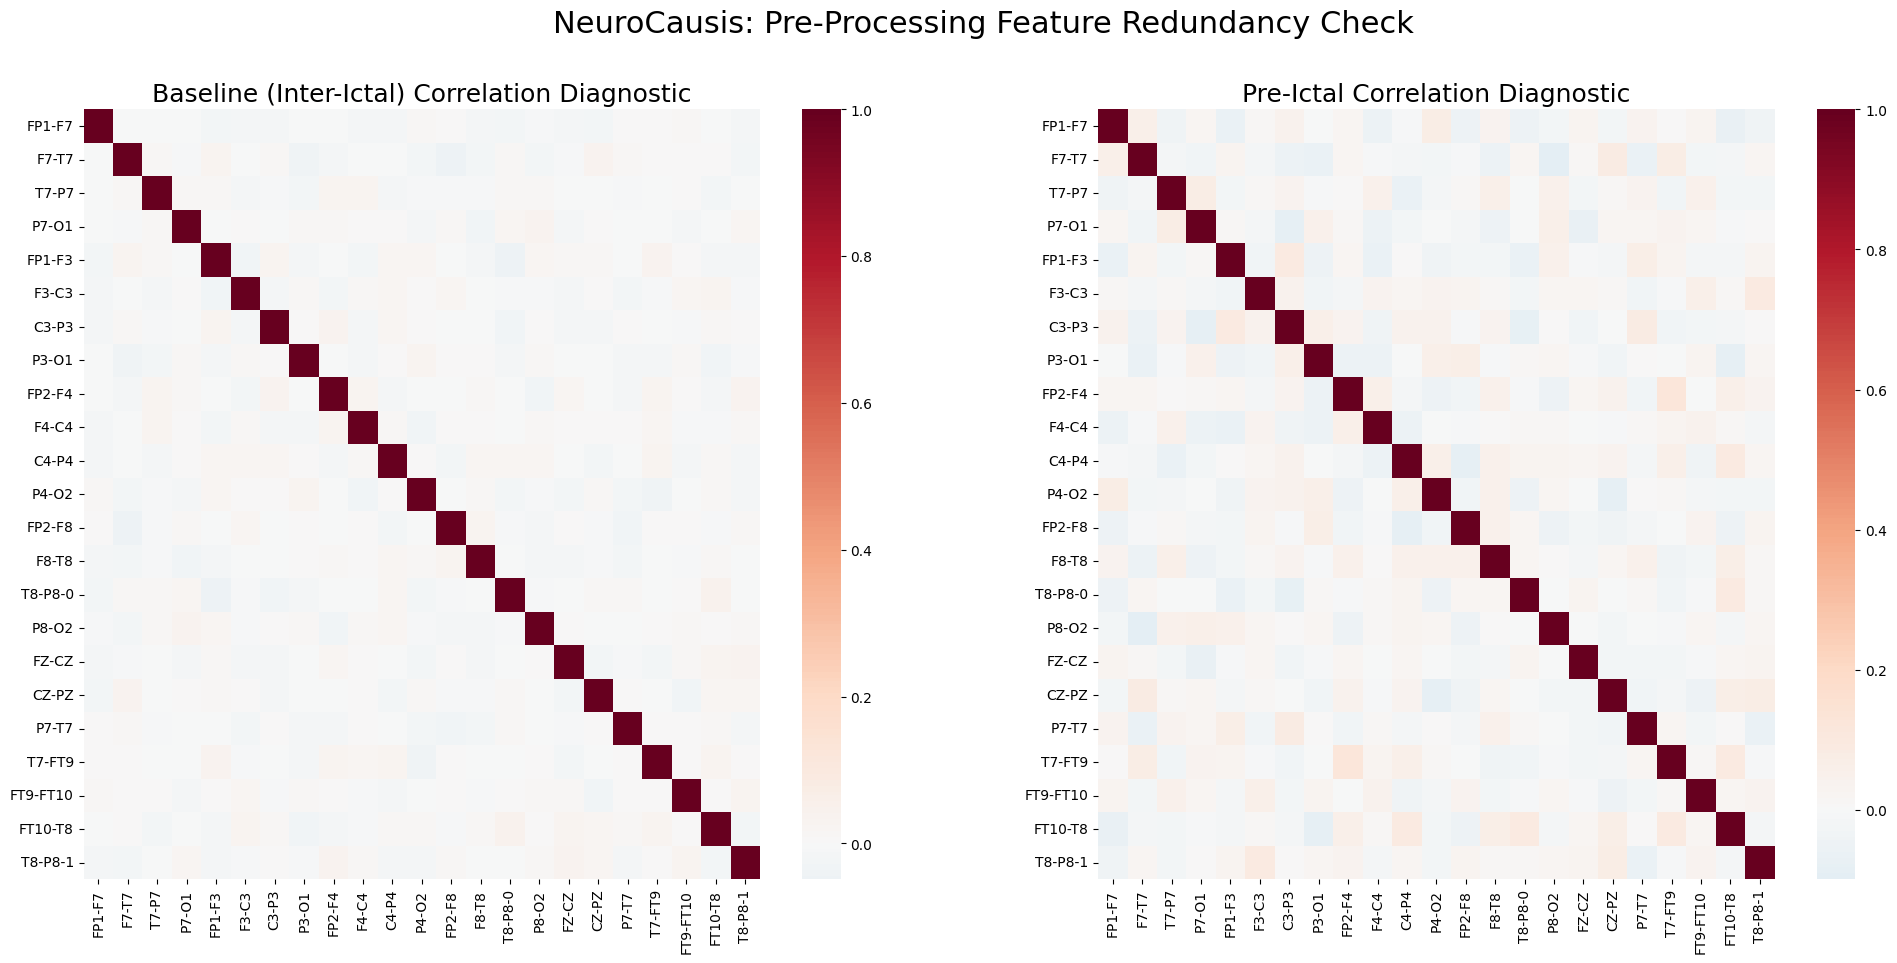

In [87]:
import seaborn as sns
import pandas as pd

def plot_diagnostic_heatmaps(inter_data, pre_data, labels):
    """
    Generates correlation heatmaps as a preprocessing diagnostic.
    Used to identify feature redundancy and signal quality.
    """
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))

    # Convert arrays to DataFrames for easier labeling
    df_inter = pd.DataFrame(inter_data, columns=labels)
    df_pre = pd.DataFrame(pre_data, columns=labels)

    # Calculate Pearson Correlation Matrices
    corr_inter = df_inter.corr()
    corr_pre = df_pre.corr()

    # Plot Baseline
    sns.heatmap(corr_inter, annot=False, cmap='RdBu_r', center=0, ax=axes[0])
    axes[0].set_title("Baseline (Inter-Ictal) Correlation Diagnostic", fontsize=18)

    # Plot Pre-Ictal
    sns.heatmap(corr_pre, annot=False, cmap='RdBu_r', center=0, ax=axes[1])
    axes[1].set_title("Pre-Ictal Correlation Diagnostic", fontsize=18)

    plt.suptitle("NeuroCausis: Pre-Processing Feature Redundancy Check", fontsize=22)
    plt.show()

# Execution using your existing cleaned data
plot_diagnostic_heatmaps(inter_ictal_final, pre_ictal_final, channel_names)

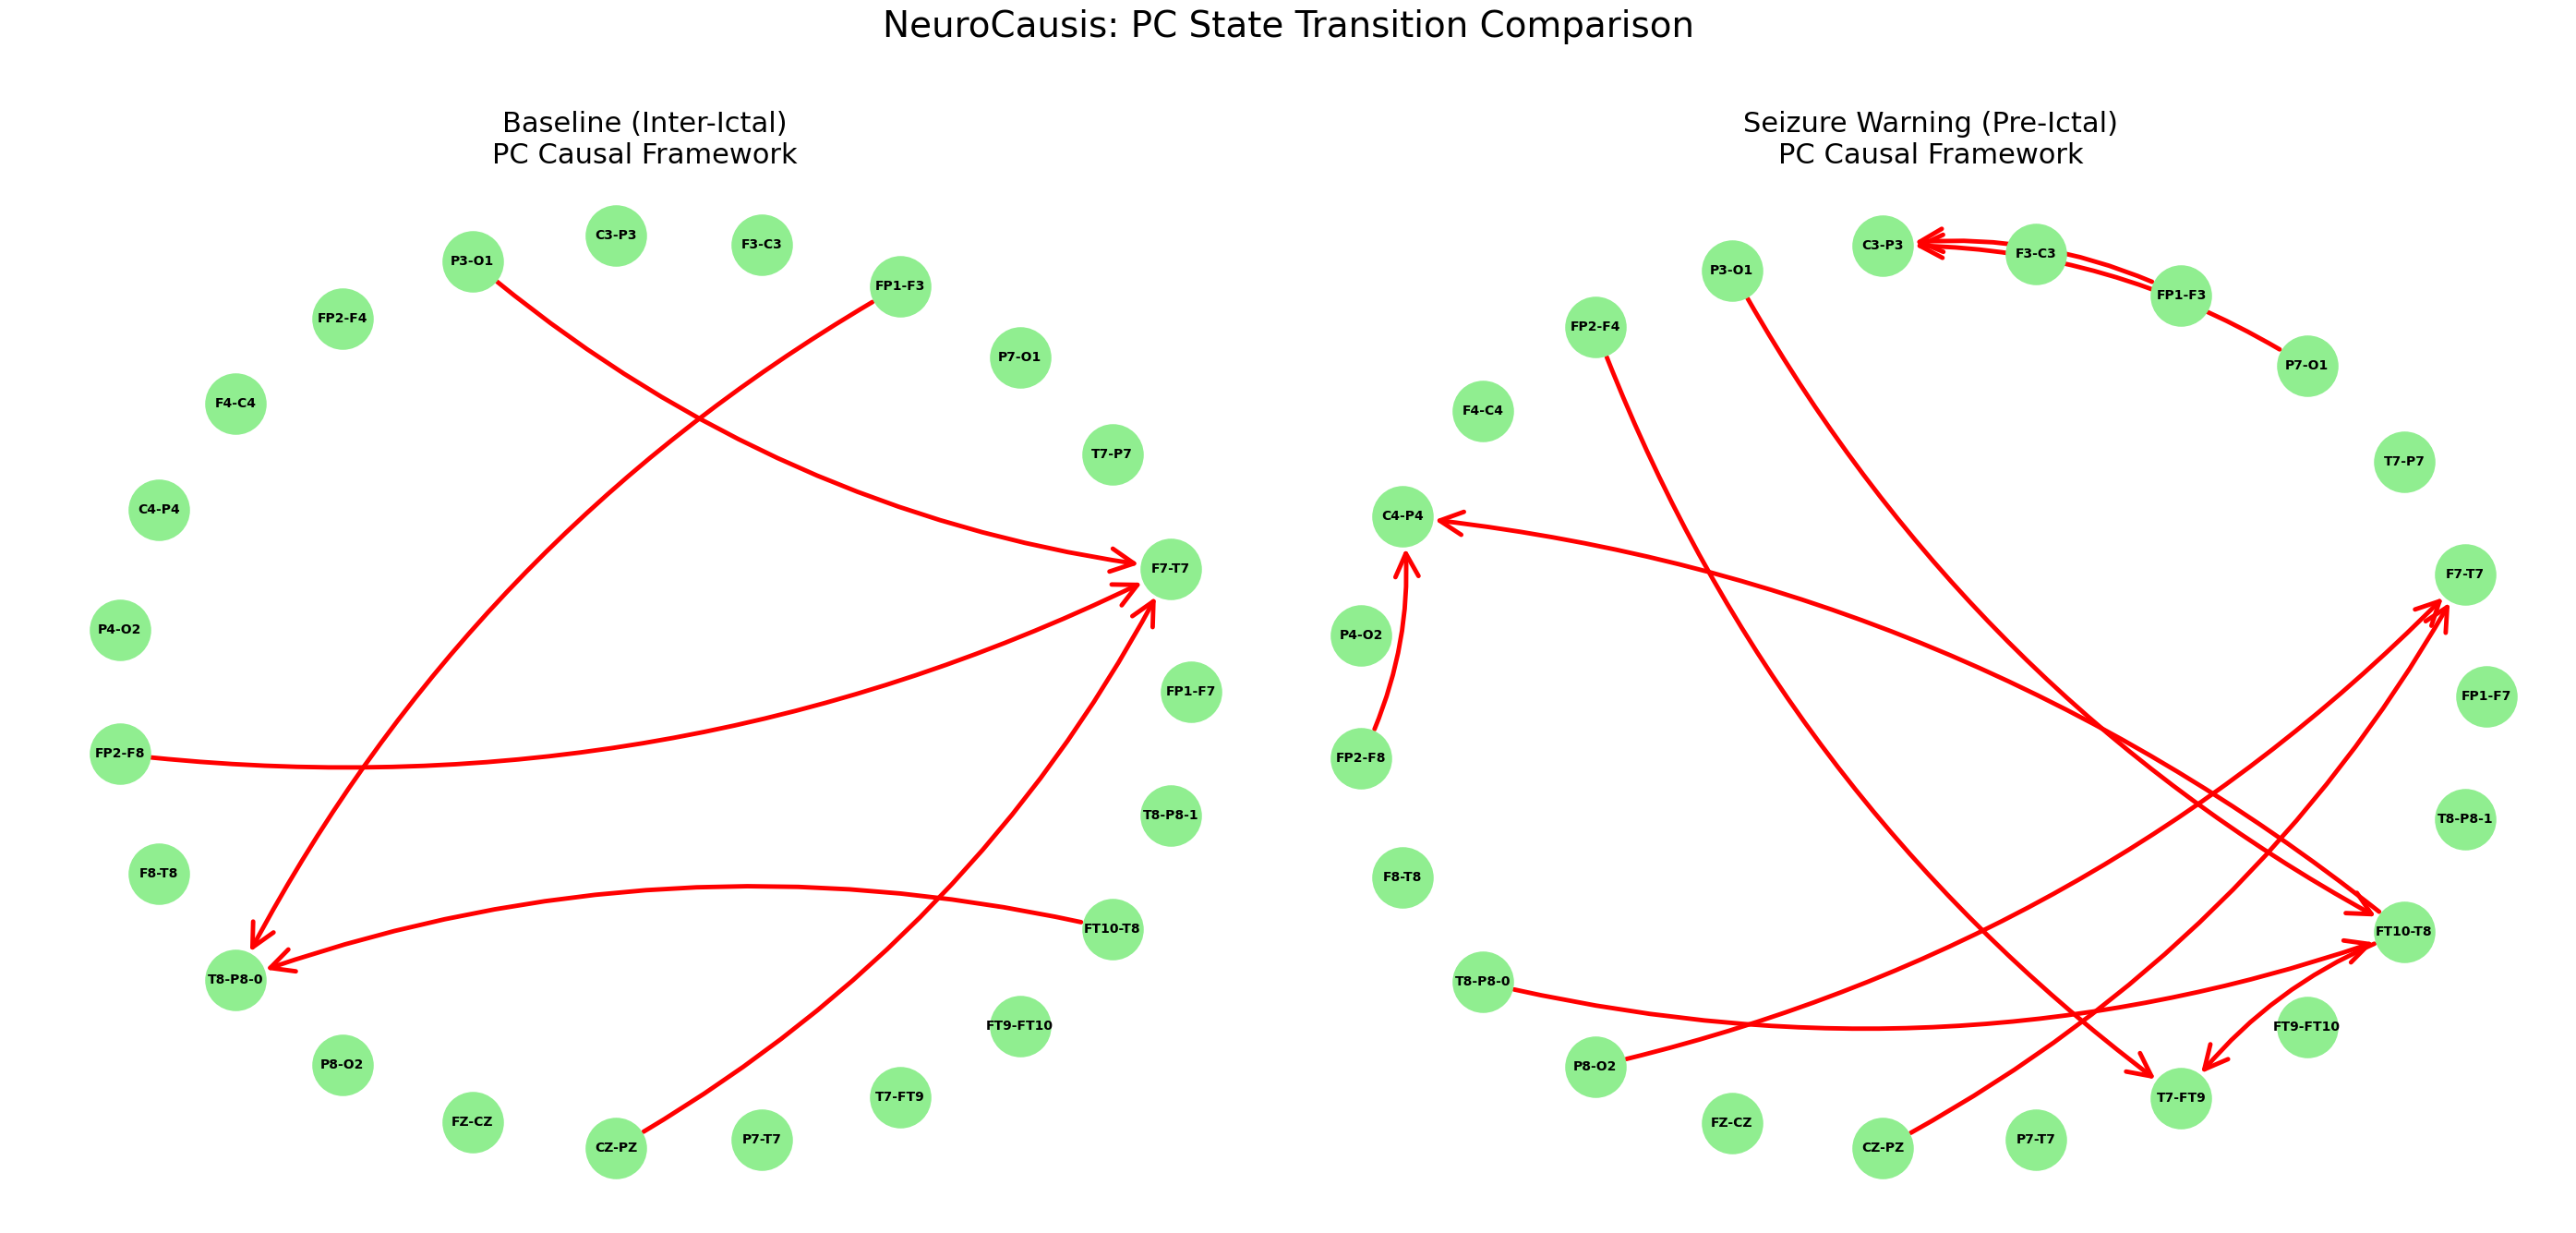

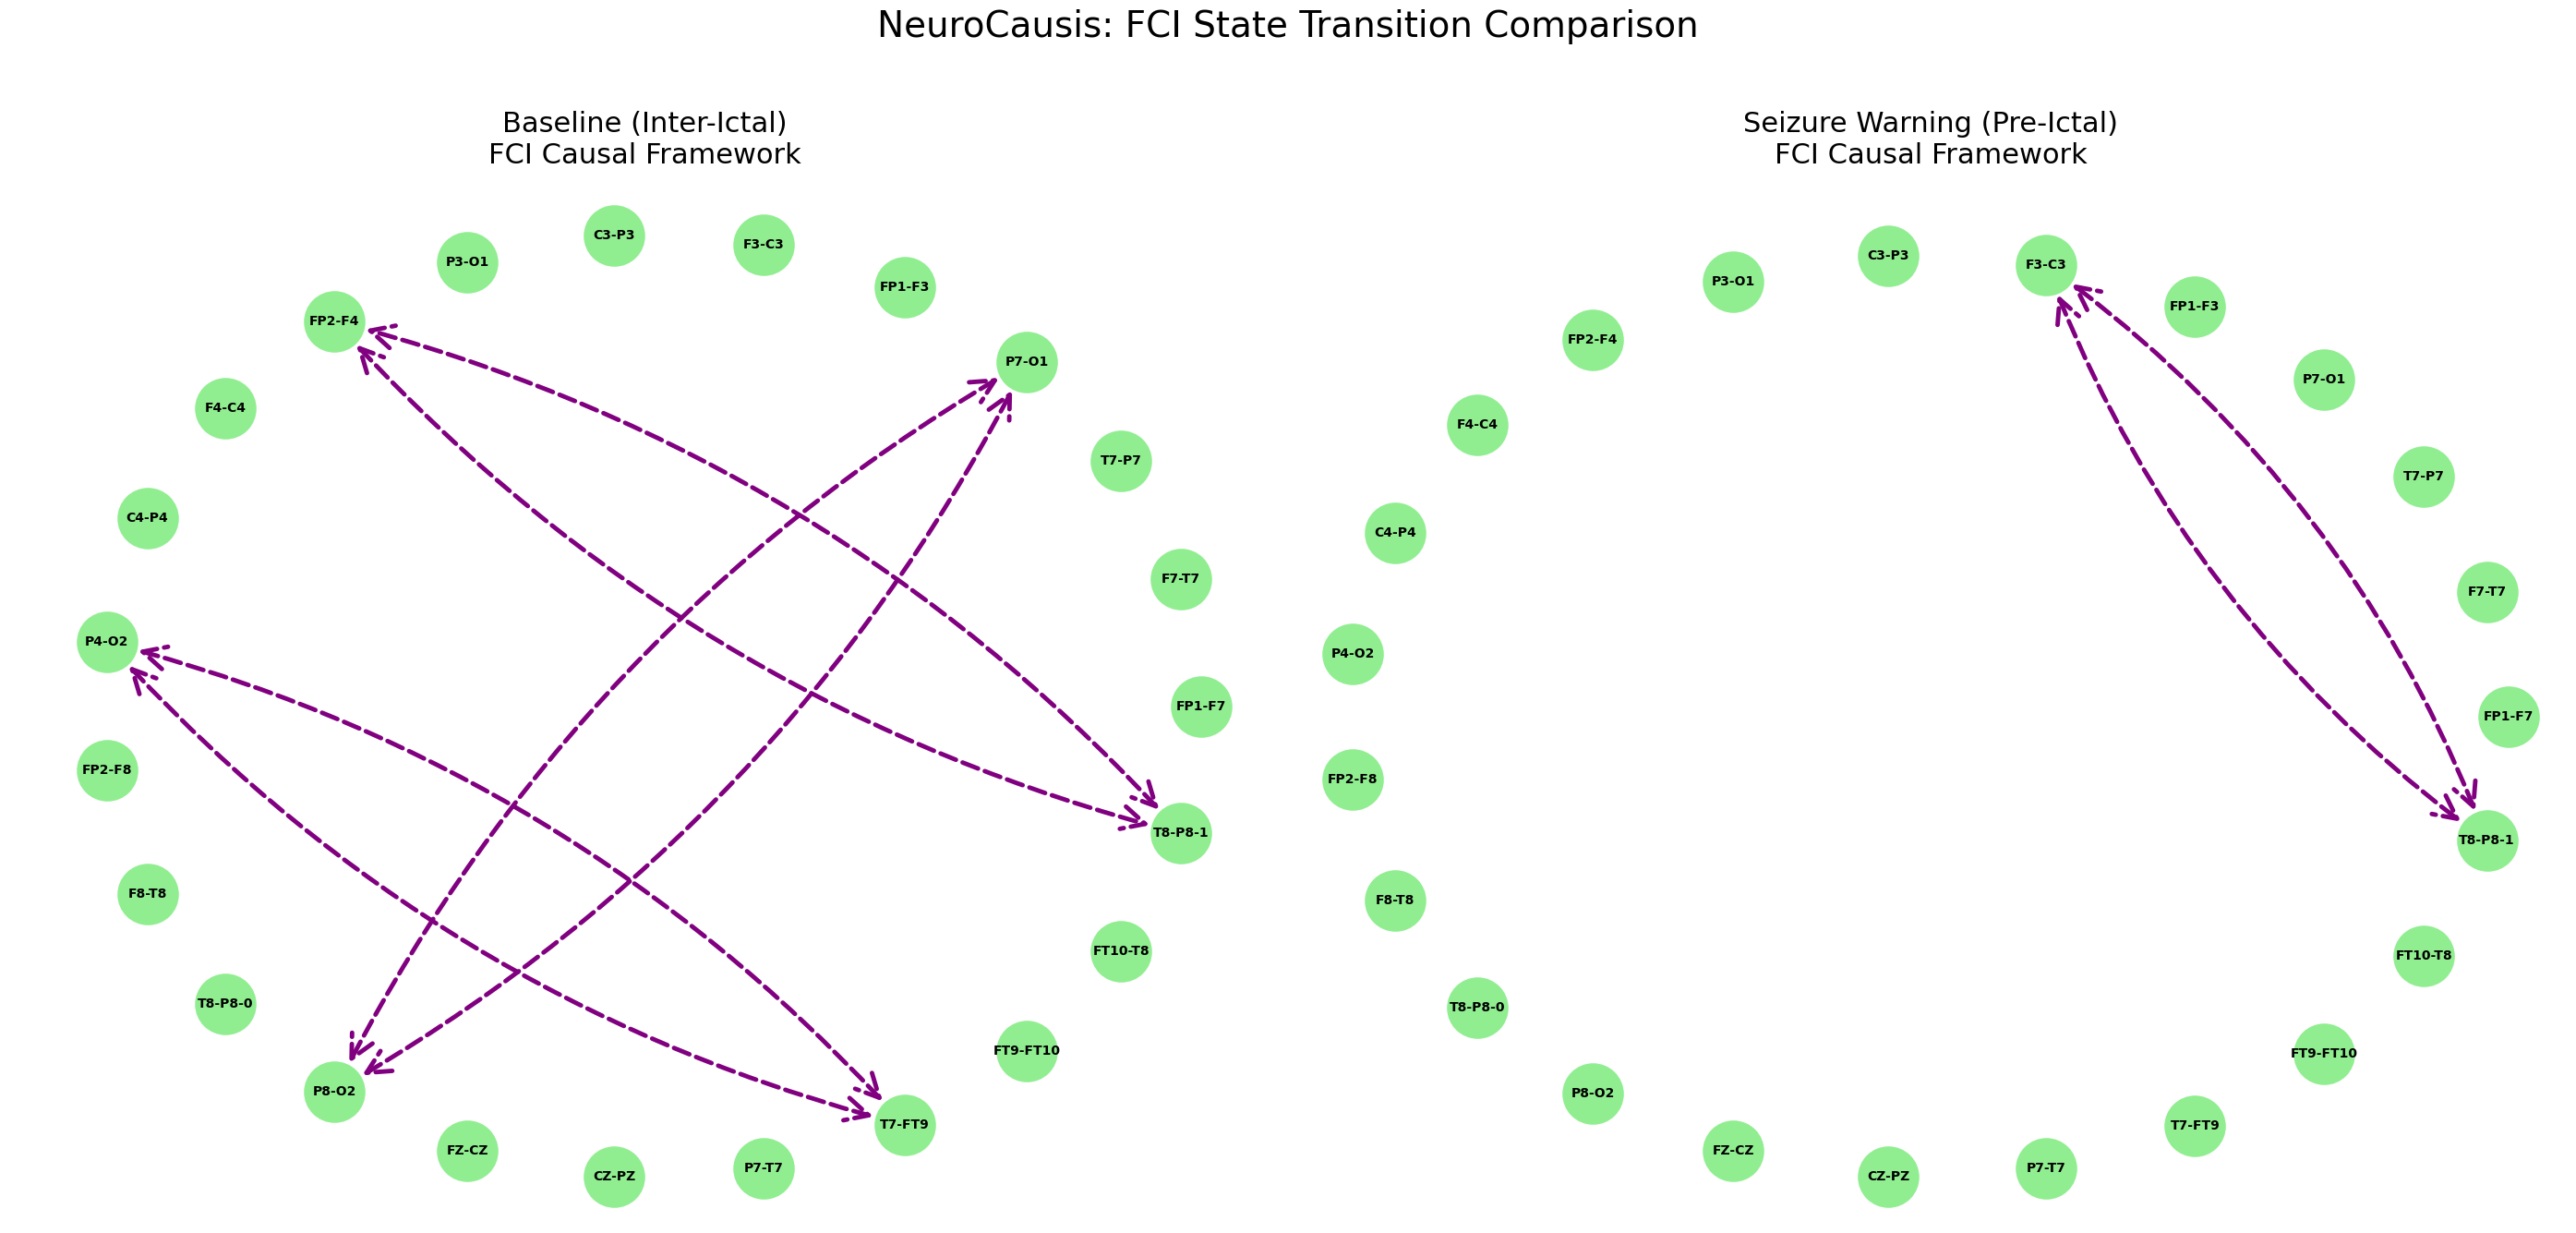

In [85]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from sklearn.preprocessing import StandardScaler


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

def get_stable_features(state_label, eeg_data, metadata):
    """Ensures both algorithms ingest the exact same stabilized data."""
    indices = np.where(metadata == state_label)[0]
    if len(indices) == 0: return None

    # Extract Gamma features (Assumes get_gamma_power is defined in your environment)
    features = np.array([get_gamma_power(seg, sfreq=100) for seg in eeg_data[indices]])

    # Apply fixed-seed jitter for numerical stability to prevent matrix singularity
    rng = np.random.default_rng(RANDOM_SEED)
    jitter = rng.normal(0, 1e-9, features.shape)
    return StandardScaler().fit_transform(features + jitter)


def plot_discovery_comparison(inter_data, pre_data, labels, method='PC'):
    """Renders causal maps with high-visibility arrows and proper node margins."""
    fig, axes = plt.subplots(1, 2, figsize=(28, 14))
    pos = nx.circular_layout(labels)
    datasets = [inter_data, pre_data]
    titles = ["Baseline (Inter-Ictal)", "Seizure Warning (Pre-Ictal)"]

    for i, (data, title) in enumerate(zip(datasets, titles)):
        G = nx.MultiDiGraph() # MultiDiGraph helps render bidirectional edges clearly
        G.add_nodes_from(labels)

        if method == 'PC':
            # PC assumes Causal Sufficiency (no hidden drivers)
            res = pc(data, alpha=0.05, indepTest='gauss', show_progress=False)
            adj = res.G.graph
            for r in range(len(labels)):
                for c in range(len(labels)):
                    if adj[r, c] == -1 and adj[c, r] == 1:
                        G.add_edge(labels[r], labels[c], color='red', style='solid', arrow_type='->')
        else:
            # FCI handles Latent Confounders (Hidden subcortical sources)
            res_tuple = fci(data, alpha=0.05, indepTest='gauss', show_progress=False)
            adj = res_tuple[0].graph # Unpack the graph object from the tuple
            for r in range(len(labels)):
                for c in range(len(labels)):
                    # Bidirected Edge: A <-> B (Proof of hidden common cause)
                    if adj[r, c] == 2 and adj[c, r] == 2:
                        G.add_edge(labels[r], labels[c], color='purple', style='dashed', arrow_type='<->')
                    # Directed Edge: A -> B (Evidence of direct influence)
                    elif adj[r, c] == 2 and adj[c, r] == 3:
                        G.add_edge(labels[r], labels[c], color='red', style='solid', arrow_type='->')

        # Draw Nodes with distinct green circles
        nx.draw_networkx_nodes(G, pos, ax=axes[i], node_color='lightgreen', node_size=2200)
        nx.draw_networkx_labels(G, pos, ax=axes[i], font_size=10, font_weight='bold')

        # High-Visibility Edge Drawing Loop
        for u, v, k, d in G.edges(data=True, keys=True):
            nx.draw_networkx_edges(
                G, pos, ax=axes[i],
                edgelist=[(u, v)],
                edge_color=d['color'],
                style=d['style'],
                arrows=True,
                arrowstyle=d['arrow_type'], # Force triangular head rendering
                arrowsize=45,               # Massive arrows for visibility
                width=3.5,                  # Thicker lines
                connectionstyle="arc3,rad=0.15", # Curves edges to reveal bidirectional flow
                min_source_margin=25,       # Keeps arrow tail outside node boundary
                min_target_margin=25        # Keeps arrowhead visible on the node edge
            )

        axes[i].set_title(f"{title}\n{method} Causal Framework", fontsize=22, pad=20)
        axes[i].axis('off')

    plt.suptitle(f"NeuroCausis: {method} State Transition Comparison", fontsize=28, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


inter_ictal_final = get_stable_features('inter-icta', eeg_segments_reshaped, seizure_state_metadata)
pre_ictal_final = get_stable_features('pre-ictal', eeg_segments_reshaped, seizure_state_metadata)

if inter_ictal_final is not None and pre_ictal_final is not None:
    # 1. Run PC: Best for visualizing assumed direct pathways
    plot_discovery_comparison(inter_ictal_final, pre_ictal_final, channel_names, method='PC')

    # 2. Run FCI: Best for identifying subcortical 'Hidden' drivers
    plot_discovery_comparison(inter_ictal_final, pre_ictal_final, channel_names, method='FCI')